Importing Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
!pip install tqdm  
from tqdm import tqdm

Data Augmentation

In [5]:


transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness=0.2,  # randomly change brightness
        contrast=0.2,    # randomly change contrast
        saturation=0.2,  # randomly change saturation
        hue=0.1          # randomly change hue
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Load the Dataset

In [6]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_set, val_set = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)


Resnet Model

In [7]:
import torch.nn as nn
from torchvision import models

def get_resnet(model_type='resnet50', num_classes=10, pretrained=True):
    if model_type == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
    elif model_type == 'resnet152':
        model = models.resnet152(pretrained=pretrained)
    else:
        raise ValueError("Unsupported model_type")

    # Modify first conv layer for CIFAR-10 (32x32 images)
    model.conv1 = nn.Conv2d(
        in_channels=3,
        out_channels=64,
        kernel_size=3,
        stride=1,
        padding=1,
        bias=False
    )

    # Remove maxpool layer to preserve spatial dimensions
    model.maxpool = nn.Identity()

    # Full fine-tuning: set requires_grad=True for all params
    for param in model.parameters():
        param.requires_grad = True

     # Replace the final fully connected layer for CIFAR-10
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

In [8]:
import torch
from tqdm import tqdm
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, mode='max'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode

    def __call__(self, score, model, path='best_model.pth'):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, path)
        elif ((self.mode == 'max' and score <= self.best_score) or
              (self.mode == 'min' and score >= self.best_score)):
            self.counter += 1
            print(f"⚠️ EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, path)
            self.counter = 0

    def save_checkpoint(self, model, path):
        torch.save(model.state_dict(), path)
        

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    early_stopper = EarlyStopping(patience=patience, mode='max')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        loop = tqdm(train_loader, leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            loop.set_description("Train")
            loop.set_postfix(loss=loss.item(), acc=100. * correct_train / total_train)

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # -------------------------
        # Validation
        # -------------------------
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

        # -------------------------
        # Early Stopping Check
        # -------------------------
        early_stopper(val_acc, model, path='best_model.pth')
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [11]:
def plot_losses(train_losses, val_losses, title):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
def evaluate_model(model, test_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_score.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    # Classification report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC-AUC
    y_true_bin = np.eye(10)[y_true]
    roc_auc = roc_auc_score(y_true_bin, np.array(y_score), multi_class='ovr')
    print(f"ROC-AUC (One-vs-All): {roc_auc:.4f}")

In [13]:
def plot_accuracy_and_loss(train_losses, val_losses, train_acc, val_acc, title="ResNet Training"):
    epochs = range(1, len(train_losses)+1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(epochs, train_losses, label='Train Loss')
    ax[0].plot(epochs, val_losses, label='Val Loss')
    ax[0].set_title("Loss")
    ax[0].legend()
    
    ax[1].plot(epochs, train_acc, label='Train Acc')
    ax[1].plot(epochs, val_acc, label='Val Acc')
    ax[1].set_title("Accuracy")
    ax[1].legend()
    
    plt.suptitle(title)
    plt.grid(True)
    plt.show()


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10


Train Loss: 0.7241 | Train Acc: 75.08%
Val Loss:   0.4082 | Val Acc:   86.46%

Epoch 2/10


Train Loss: 0.3471 | Train Acc: 88.12%
Val Loss:   0.3373 | Val Acc:   88.47%

Epoch 3/10


Train Loss: 0.2645 | Train Acc: 91.04%
Val Loss:   0.2784 | Val Acc:   90.51%

Epoch 4/10


Train Loss: 0.2249 | Train Acc: 92.35%
Val Loss:   0.2636 | Val Acc:   91.18%

Epoch 5/10


Train Loss: 0.1915 | Train Acc: 93.62%
Val Loss:   0.2584 | Val Acc:   91.37%

Epoch 6/10


Train Loss: 0.1707 | Train Acc: 94.06%
Val Loss:   0.2422 | Val Acc:   91.89%

Epoch 7/10


Train Loss: 0.1498 | Train Acc: 94.81%
Val Loss:   0.2487 | Val Acc:   91.71%
⚠️ EarlyStopping counter: 1 / 5

Epoch 8/10


Train Loss: 0.1399 | Train Acc: 95.21%
Val Loss:   0.2514 | Val Acc:   91.68%
⚠️ EarlyStopping counter: 2 / 5

Epoch 9/10


Train Loss: 0.1269 | Train Acc: 95.79%
Val Loss:   0.2355 | Val Acc:   92.67%

Epoch 10/10


Train Loss: 0.1179 | Train Acc: 95.95%
Val Loss:   0.2491 | Val Acc:   92.25%
⚠️ EarlyStopping counter: 1 / 5


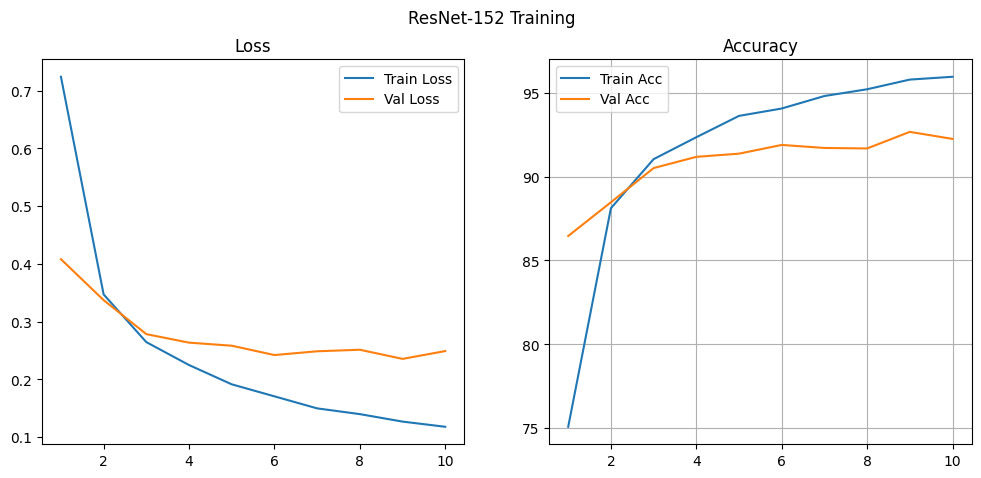

In [14]:
model = get_resnet('resnet152')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model, train_losses, val_losses, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10
)

plot_accuracy_and_loss(train_losses, val_losses, train_acc, val_acc, title="ResNet-152 Training")


In [15]:
classes = train_data.classes
print("Classes:", classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


              precision    recall  f1-score   support

    airplane       0.95      0.96      0.95      1000
  automobile       0.96      0.97      0.96      1000
        bird       0.93      0.94      0.94      1000
         cat       0.87      0.92      0.90      1000
        deer       0.94      0.97      0.96      1000
         dog       0.96      0.84      0.89      1000
        frog       0.95      0.97      0.96      1000
       horse       0.98      0.96      0.97      1000
        ship       0.96      0.98      0.97      1000
       truck       0.96      0.95      0.95      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



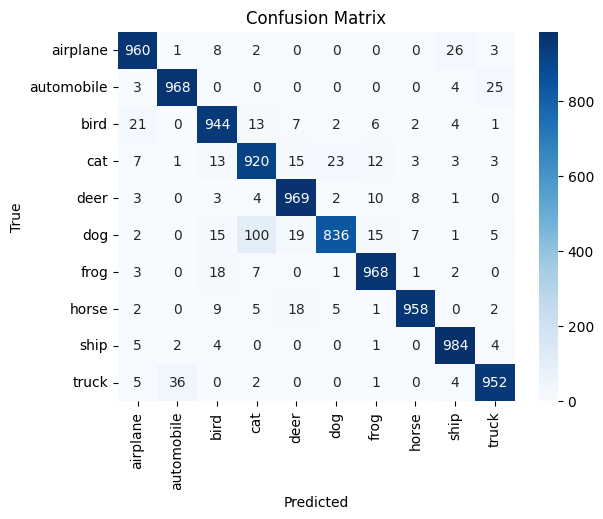

ROC-AUC (One-vs-All): 0.9979


In [16]:
evaluate_model(model, test_loader,classes)

Class-wise Precision, Recall and F1-Score:
airplane: Precision=0.950, Recall=0.960, F1-score=0.955
automobile: Precision=0.960, Recall=0.968, F1-score=0.964
bird: Precision=0.931, Recall=0.944, F1-score=0.937
cat: Precision=0.874, Recall=0.920, F1-score=0.896
deer: Precision=0.943, Recall=0.969, F1-score=0.956
dog: Precision=0.962, Recall=0.836, F1-score=0.895
frog: Precision=0.955, Recall=0.968, F1-score=0.961
horse: Precision=0.979, Recall=0.958, F1-score=0.968
ship: Precision=0.956, Recall=0.984, F1-score=0.970
truck: Precision=0.957, Recall=0.952, F1-score=0.954


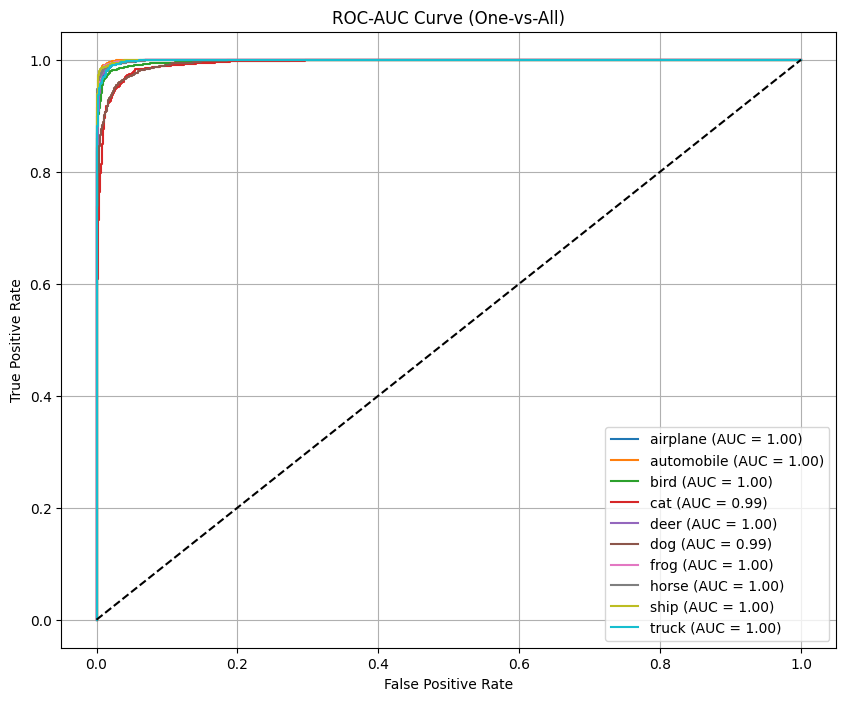

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test_metrics_and_roc(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []
    y_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Per-class precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_names)))

    print("Class-wise Precision, Recall and F1-Score:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={f1[i]:.3f}")

    # ROC-AUC per class (one-vs-all)
    y_true_bin = np.eye(len(class_names))[y_true]  # one-hot encoding

    plt.figure(figsize=(10,8))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # random guess line
    plt.title("ROC-AUC Curve (One-vs-All)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


test_metrics_and_roc(model, test_loader, test_data.classes)


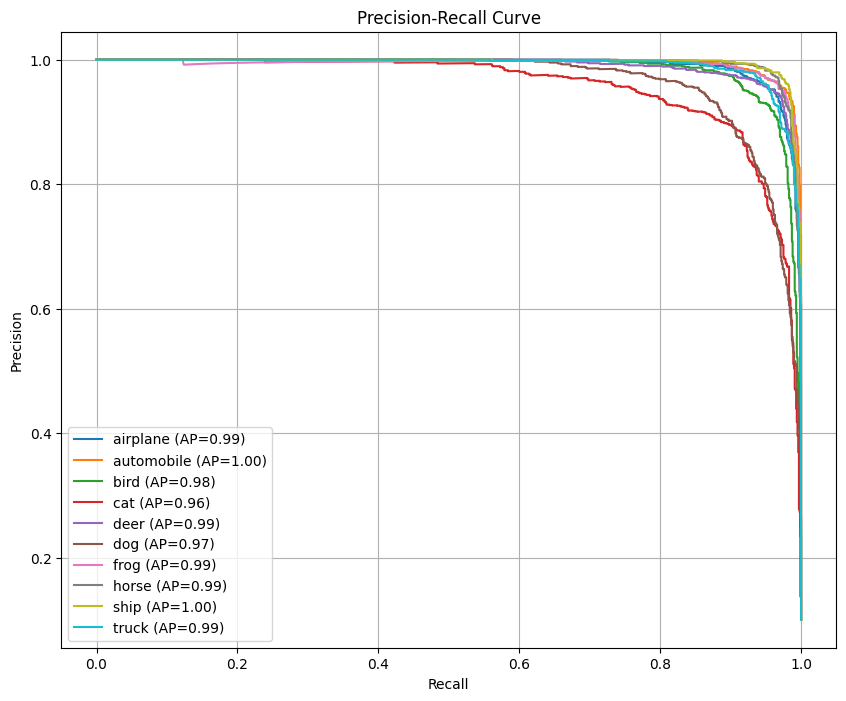

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve(model, data_loader, class_names, device):
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    y_true_bin = np.eye(len(class_names))[y_true]  # One-hot encoding

    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(class_names):
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        ap_score = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall_curve, precision_curve, label=f"{cls} (AP={ap_score:.2f})")

    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


# plot_precision_recall_curve(model, test_loader, test_data.classes, device)
plot_precision_recall_curve(model, test_loader, test_data.classes, device)